# Modelagem de Regressão - Preços de Energia
**Regressão Linear e Random Forest para Previsão de Preços**

---

## 1. Setup e Bibliotecas

In [79]:
# Bibliotecas de Manipulação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# Configurações
import os
import random

# Seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

# Visualização
sns.set(style="white")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = '12'
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.filterwarnings('ignore')

In [8]:
# caminhos relativos ao notebook atual
path_raw = "../data/raw/"

df_price = pd.read_csv(path_raw + 'price_vars_daily.csv')

## 2. Preparação dos Dados

In [10]:
# Converter data e ordenar
df_price['anomesdia'] = pd.to_datetime(df_price['anomesdia'])
df_price = df_price.sort_values('anomesdia').reset_index(drop=True)

print(f"Dataset Original:")
print(f"   Período: {df_price['anomesdia'].min().date()} a {df_price['anomesdia'].max().date()}")
print(f"   Total de observações: {len(df_price)}")
print(f"   Colunas: {df_price.shape[1]}")
print(f"\nPrimeiras linhas:")
display(df_price.head())

Dataset Original:
   Período: 2014-12-31 a 2018-12-31
   Total de observações: 1462
   Colunas: 8

Primeiras linhas:


,anomesdia,geracao_gas_fossil,geracao_carvao_duro,carga_total_real,preco_dia_seguinte,preco_real,temperatura,velocidade_vento
0,2014-12-31,4844.0000,4821.0000,25385.0000,50.1000,65.4100,272.4915,2.0000
1,2015-01-01,4187.7917,4099.4583,23966.9583,45.0317,62.0908,277.0012,1.9333
2,2015-01-02,3566.1667,1258.1250,27188.5417,17.5983,69.4437,277.9512,1.5750
3,2015-01-03,3451.7917,1375.9583,25097.7500,25.3421,65.2233,278.8297,1.5583
4,2015-01-04,3526.1250,2315.2917,27104.9167,30.6583,58.9121,279.6434,1.2500


## 3. Engenharia de Features

In [65]:
# Criar cópia
df = df_price.copy()

print("🔧 Criando Features...\n")

# 1. Features Temporais
print("Features Temporais")
df['ano'] = df['anomesdia'].dt.year
df['mes'] = df['anomesdia'].dt.month
df['dia'] = df['anomesdia'].dt.day
df['dia_semana'] = df['anomesdia'].dt.dayofweek
df['dia_ano'] = df['anomesdia'].dt.dayofyear
df['trimestre'] = df['anomesdia'].dt.quarter
df['fim_semana'] = df['dia_semana'].isin([5, 6]).astype(int)

# 2. Features Cíclicas (capturar sazonalidade)
print("Features Cíclicas")
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
df['dia_ano_sin'] = np.sin(2 * np.pi * df['dia_ano'] / 365)
df['dia_ano_cos'] = np.cos(2 * np.pi * df['dia_ano'] / 365)
df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

# 3. Lags (valores defasados)
print("Features de Lag")
for lag in [1, 2, 3, 7, 14, 30]:
    df[f'preco_real_lag_{lag}'] = df['preco_real'].shift(lag)
    df[f'carga_lag_{lag}'] = df['carga_total_real'].shift(lag)

# 4. Rolling Statistics
print("Rolling Statistics")
for window in [7, 14, 30]:
    df[f'preco_rolling_mean_{window}'] = df['preco_real'].rolling(window=window).mean()
    df[f'preco_rolling_std_{window}'] = df['preco_real'].rolling(window=window).std()
    df[f'carga_rolling_mean_{window}'] = df['carga_total_real'].rolling(window=window).mean()

# 5. Features de Interação
print("Features de Interação")
df['geracao_total'] = df['geracao_gas_fossil'] + df['geracao_carvao_duro']
df['razao_gas_carvao'] = df['geracao_gas_fossil'] / (df['geracao_carvao_duro'] + 1)
df['carga_per_temp'] = df['carga_total_real'] / df['temperatura']

# Remover NaN
df = df.dropna().reset_index(drop=True)

print(f"\n Feature Engineering Concluída!")
print(f"   Total de features criadas: {df.shape[1] - df_price.shape[1]}")
print(f"   Total de features: {df.shape[1]}")
print(f"   Observações restantes: {len(df)}")

🔧 Criando Features...

Features Temporais
Features Cíclicas
Features de Lag
Rolling Statistics
Features de Interação

 Feature Engineering Concluída!
   Total de features criadas: 37
   Total de features: 45
   Observações restantes: 1432


## 4. Seleção de Features e Target

In [14]:
# Definir target
target = 'preco_real'

# Features a excluir
exclude_cols = ['anomesdia', 'preco_real', 'preco_dia_seguinte']

# Selecionar features
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target]

print(f"Preparação X e y:")
print(f"   Features selecionadas: {len(feature_cols)}")
print(f"   Target: {target}")
print(f"   Shape X: {X.shape}")
print(f"   Shape y: {y.shape}")
print(f"\nLista de Features (primeiras 20):")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"   {i:2d}. {col}")
if len(feature_cols) > 20:
    print(f"   ... e mais {len(feature_cols) - 20} features")

Preparação X e y:
   Features selecionadas: 42
   Target: preco_real
   Shape X: (1432, 42)
   Shape y: (1432,)

Lista de Features (primeiras 20):
    1. geracao_gas_fossil
    2. geracao_carvao_duro
    3. carga_total_real
    4. temperatura
    5. velocidade_vento
    6. ano
    7. mes
    8. dia
    9. dia_semana
   10. dia_ano
   11. trimestre
   12. fim_semana
   13. mes_sin
   14. mes_cos
   15. dia_ano_sin
   16. dia_ano_cos
   17. dia_semana_sin
   18. dia_semana_cos
   19. preco_real_lag_1
   20. carga_lag_1
   ... e mais 22 features


## 5. Divisão Treino-Teste (Time Series Split)

Divisão Treino-Teste (mantendo ordem temporal):

TREINO:
   Período: 2015-01-30 a 2018-03-19
   Tamanho: 1145 (80.0%)

TESTE:
   Período: 2018-03-20 a 2018-12-31
   Tamanho: 287 (20.0%)


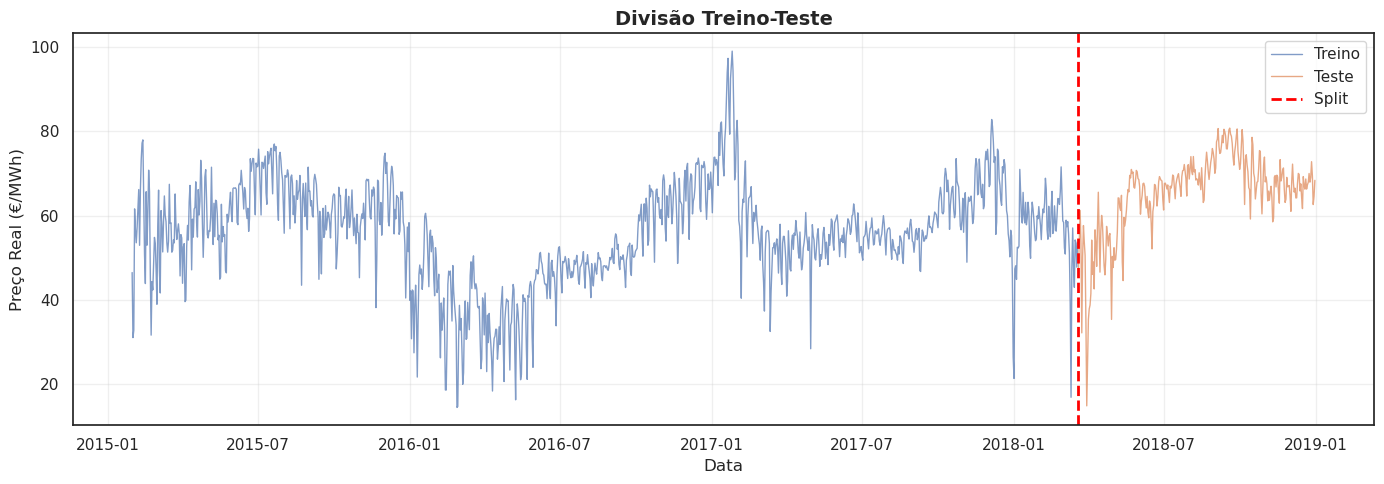

In [16]:
# Divisão temporal 80/20
split_index = int(len(df) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

train_dates = df['anomesdia'][:split_index]
test_dates = df['anomesdia'][split_index:]

print(f"Divisão Treino-Teste (mantendo ordem temporal):")
print(f"\nTREINO:")
print(f"   Período: {train_dates.min().date()} a {train_dates.max().date()}")
print(f"   Tamanho: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"\nTESTE:")
print(f"   Período: {test_dates.min().date()} a {test_dates.max().date()}")
print(f"   Tamanho: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Visualizar
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_dates.values, y_train.values, label='Treino', alpha=0.7, linewidth=1)
ax.plot(test_dates.values, y_test.values, label='Teste', alpha=0.7, linewidth=1)
ax.axvline(x=test_dates.min(), color='red', linestyle='--', linewidth=2, label='Split')
ax.set_xlabel('Data')
ax.set_ylabel('Preço Real (€/MWh)')
ax.set_title('Divisão Treino-Teste', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Normalização

In [18]:
# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter para DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Dados normalizados (StandardScaler)")
print(f"\nEstatísticas após normalização (5 primeiras features):")
print(X_train_scaled.iloc[:, :5].describe().loc[['mean', 'std']])

Dados normalizados (StandardScaler)

Estatísticas após normalização (5 primeiras features):
      geracao_gas_fossil  geracao_carvao_duro  carga_total_real  temperatura  \
mean              0.0000               0.0000            0.0000      -0.0000   
std               1.0004               1.0004            1.0004       1.0004   

      velocidade_vento  
mean           -0.0000  
std             1.0004  


In [86]:
train_path = "../data/processed/X_train_scaled.csv"
test_path  = "../data/processed/X_test_scaled.csv"

X_train_scaled.to_csv(train_path, index=True)
X_test_scaled.to_csv(test_path, index=True)

print(f"\nArquivos salvos em:\n- {train_path}\n- {test_path}")


Arquivos salvos em:
- ../data/processed/X_train_scaled.csv
- ../data/processed/X_test_scaled.csv


## 7. Funções de Métricas

In [20]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calcula métricas completas de regressão
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    # R² Ajustado
    n = len(y_true)
    p = X_train.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # MPE (Mean Percentage Error)
    mpe = np.mean((y_true - y_pred) / y_true) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R²': r2,
        'R² Ajustado': r2_adj,
        'MAPE (%)': mape,
        'MPE (%)': mpe
    }

def print_metrics(metrics):
    """
    Imprime métricas formatadas
    """
    print(f"\n{'='*60}")
    print(f"{metrics['Model']}")
    print(f"{'='*60}")
    print(f"MAE:              €{metrics['MAE']:.4f}/MWh")
    print(f"RMSE:             €{metrics['RMSE']:.4f}/MWh")
    print(f"MSE:              {metrics['MSE']:.4f}")
    print(f"R²:               {metrics['R²']:.4f}")
    print(f"R² Ajustado:      {metrics['R² Ajustado']:.4f}")
    print(f"MAPE:             {metrics['MAPE (%)']:.4f}%")
    print(f"MPE:              {metrics['MPE (%)']:.4f}%")
    print(f"{'='*60}")

print("Funções de métricas definidas")

Funções de métricas definidas


---
# PARTE 1: REGRESSÃO LINEAR
---

## 8. Treinamento - Regressão Linear

In [67]:
print("\n" + "="*60)
print("REGRESSÃO LINEAR")
print("="*60)

# Criar e treinar
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Previsões
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

print("\nModelo treinado!")
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"Coeficientes: {len(lr_model.coef_)}")


REGRESSÃO LINEAR

Modelo treinado!
Intercept: 55.8123
Coeficientes: 42


## 9. Métricas - Regressão Linear

In [25]:
# Calcular métricas
metrics_lr_train = calculate_metrics(y_train, y_train_pred_lr, "Regressão Linear - TREINO")
metrics_lr_test = calculate_metrics(y_test, y_test_pred_lr, "Regressão Linear - TESTE")

print_metrics(metrics_lr_train)
print_metrics(metrics_lr_test)


Regressão Linear - TREINO
MAE:              €2.5273/MWh
RMSE:             €3.3510/MWh
MSE:              11.2289
R²:               0.9207
R² Ajustado:      0.9176
MAPE:             5.1164%
MPE:              -0.5886%

Regressão Linear - TESTE
MAE:              €2.8670/MWh
RMSE:             €3.8699/MWh
MSE:              14.9764
R²:               0.8382
R² Ajustado:      0.8104
MAPE:             4.9363%
MPE:              2.3788%


## 10. Visualizações - Regressão Linear

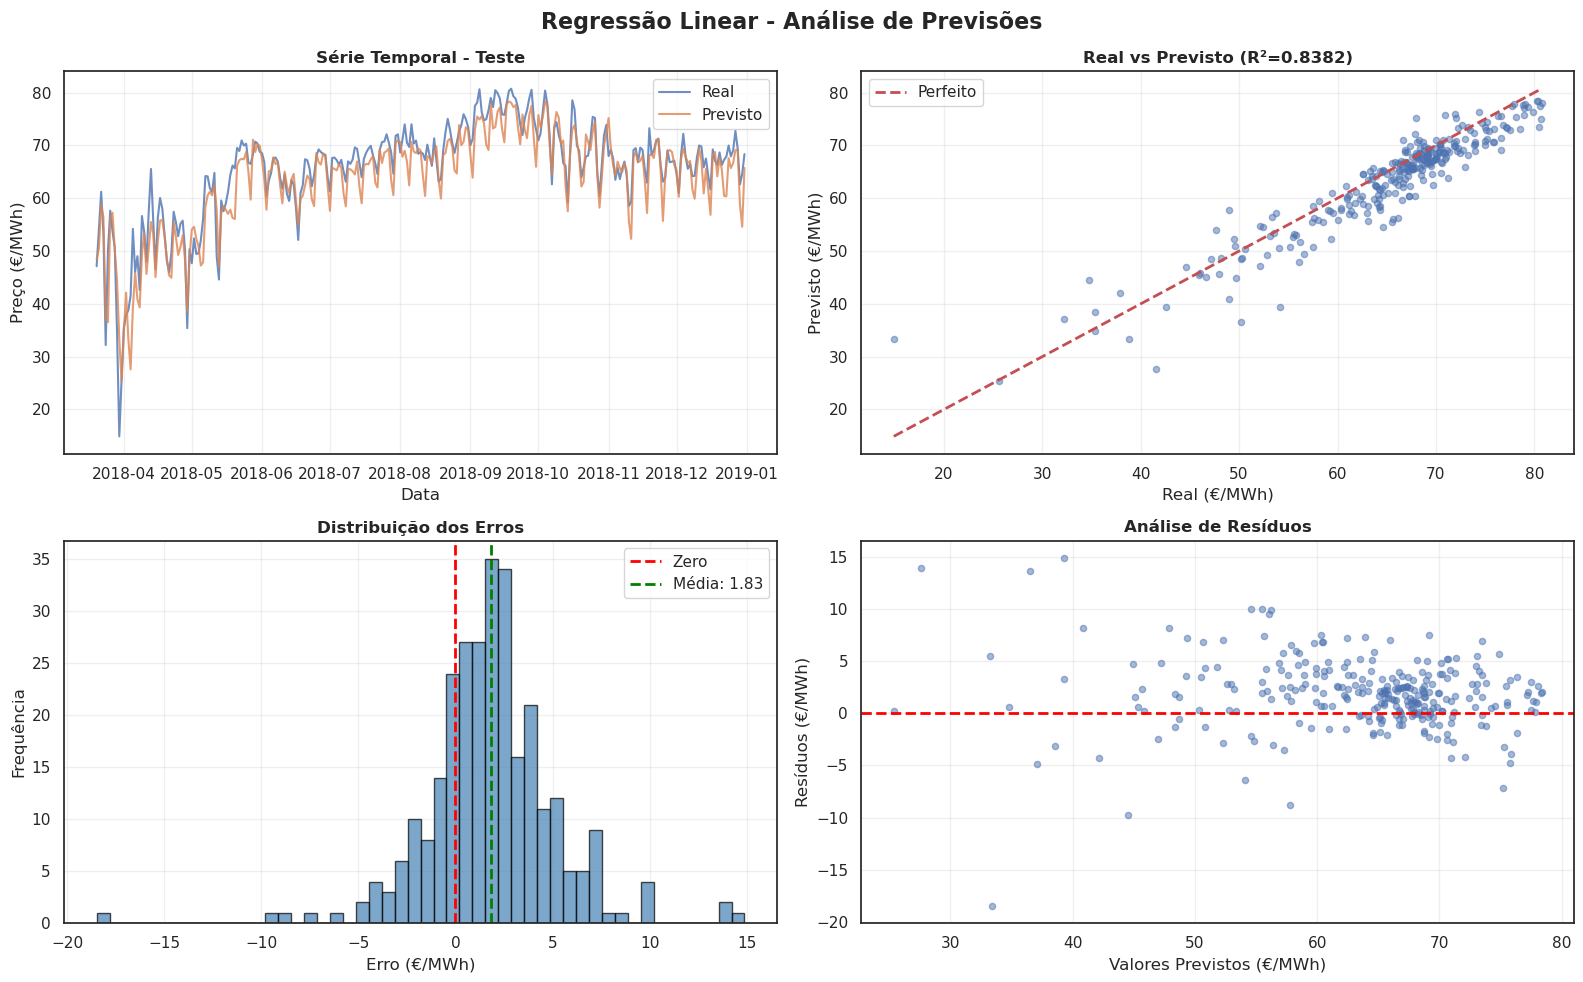

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Regressão Linear - Análise de Previsões', fontsize=16, fontweight='bold')

# 1. Série Temporal
axes[0, 0].plot(test_dates.values, y_test.values, label='Real', linewidth=1.5, alpha=0.8)
axes[0, 0].plot(test_dates.values, y_test_pred_lr, label='Previsto', linewidth=1.5, alpha=0.8)
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Preço (€/MWh)')
axes[0, 0].set_title('Série Temporal - Teste', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter Real vs Previsto
axes[0, 1].scatter(y_test, y_test_pred_lr, alpha=0.5, s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfeito')
axes[0, 1].set_xlabel('Real (€/MWh)')
axes[0, 1].set_ylabel('Previsto (€/MWh)')
axes[0, 1].set_title(f'Real vs Previsto (R²={metrics_lr_test["R²"]:.4f})', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribuição dos Erros
errors_lr = y_test.values - y_test_pred_lr
axes[1, 0].hist(errors_lr, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1, 0].axvline(x=errors_lr.mean(), color='green', linestyle='--', linewidth=2, 
                   label=f'Média: {errors_lr.mean():.2f}')
axes[1, 0].set_xlabel('Erro (€/MWh)')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Distribuição dos Erros', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Resíduos
axes[1, 1].scatter(y_test_pred_lr, errors_lr, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Valores Previstos (€/MWh)')
axes[1, 1].set_ylabel('Resíduos (€/MWh)')
axes[1, 1].set_title('Análise de Resíduos', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Feature Importance - Regressão Linear


📊 Top 15 Features (Coeficientes):
              Feature  Coeficiente
              dia_ano     -26.6434
                  mes      25.8760
       carga_per_temp      21.5674
     carga_total_real     -20.6319
 preco_rolling_mean_7      10.3855
          temperatura       3.0803
          dia_ano_cos      -2.9978
     preco_real_lag_1       2.6270
     velocidade_vento      -2.3074
          dia_ano_sin      -2.2629
                  dia       1.9144
           dia_semana      -1.9106
              mes_sin       1.8859
     preco_real_lag_2      -1.8731
preco_rolling_mean_14      -1.7579


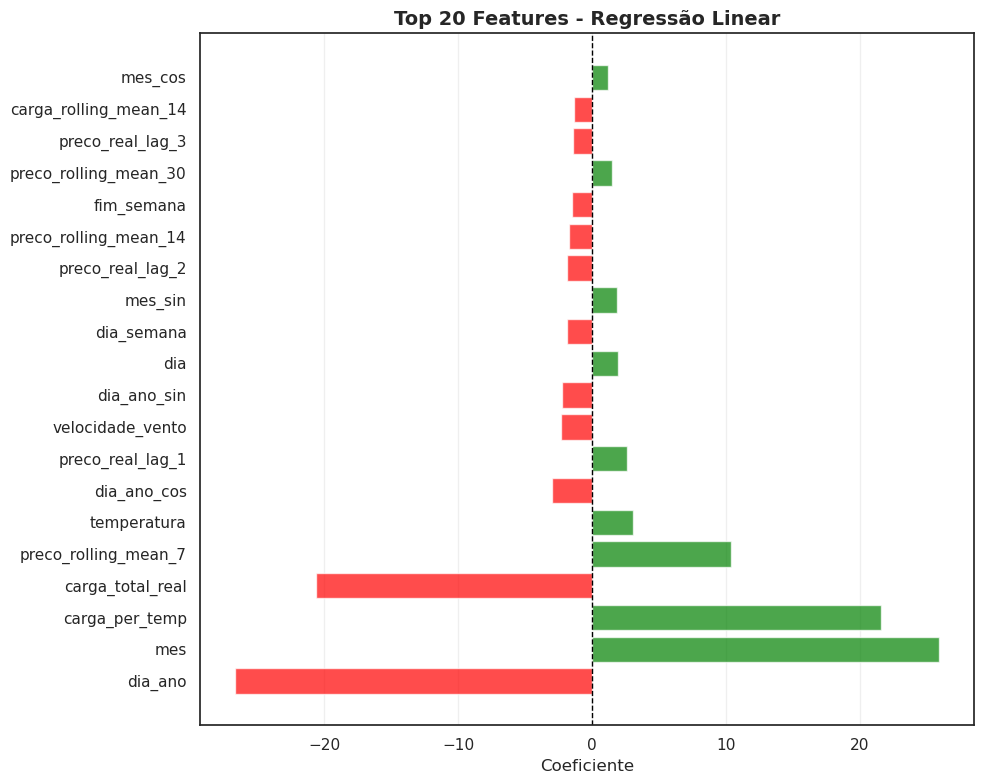

In [29]:
# Coeficientes
feat_imp_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Coeficiente': lr_model.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print("\n📊 Top 15 Features (Coeficientes):")
print(feat_imp_lr.head(15).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top20 = feat_imp_lr.head(20)
colors = ['green' if x > 0 else 'red' for x in top20['Coeficiente']]
ax.barh(range(len(top20)), top20['Coeficiente'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20['Feature'])
ax.set_xlabel('Coeficiente')
ax.set_title('Top 20 Features - Regressão Linear', fontweight='bold', fontsize=14)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---
# PARTE 2: RANDOM FOREST
---

## 12. Treinamento - Random Forest

In [32]:
print("\n" + "="*60)
print("RANDOM FOREST")
print("="*60)

# Criar e treinar
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=seed,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

# Previsões
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print("\nModelo treinado!")
print(f"Número de árvores: {rf_model.n_estimators}")
print(f"Profundidade máxima: {rf_model.max_depth}")


RANDOM FOREST

Modelo treinado!
Número de árvores: 100
Profundidade máxima: 15


## 13. Métricas - Random Forest

In [34]:
# Calcular métricas
metrics_rf_train = calculate_metrics(y_train, y_train_pred_rf, "Random Forest - TREINO")
metrics_rf_test = calculate_metrics(y_test, y_test_pred_rf, "Random Forest - TESTE")

print_metrics(metrics_rf_train)
print_metrics(metrics_rf_test)


Random Forest - TREINO
MAE:              €1.9697/MWh
RMSE:             €2.8641/MWh
MSE:              8.2033
R²:               0.9420
R² Ajustado:      0.9398
MAPE:             4.1822%
MPE:              -0.9487%

Random Forest - TESTE
MAE:              €3.1715/MWh
RMSE:             €4.3330/MWh
MSE:              18.7753
R²:               0.7972
R² Ajustado:      0.7623
MAPE:             5.5146%
MPE:              1.9297%


## 14. Visualizações - Random Forest

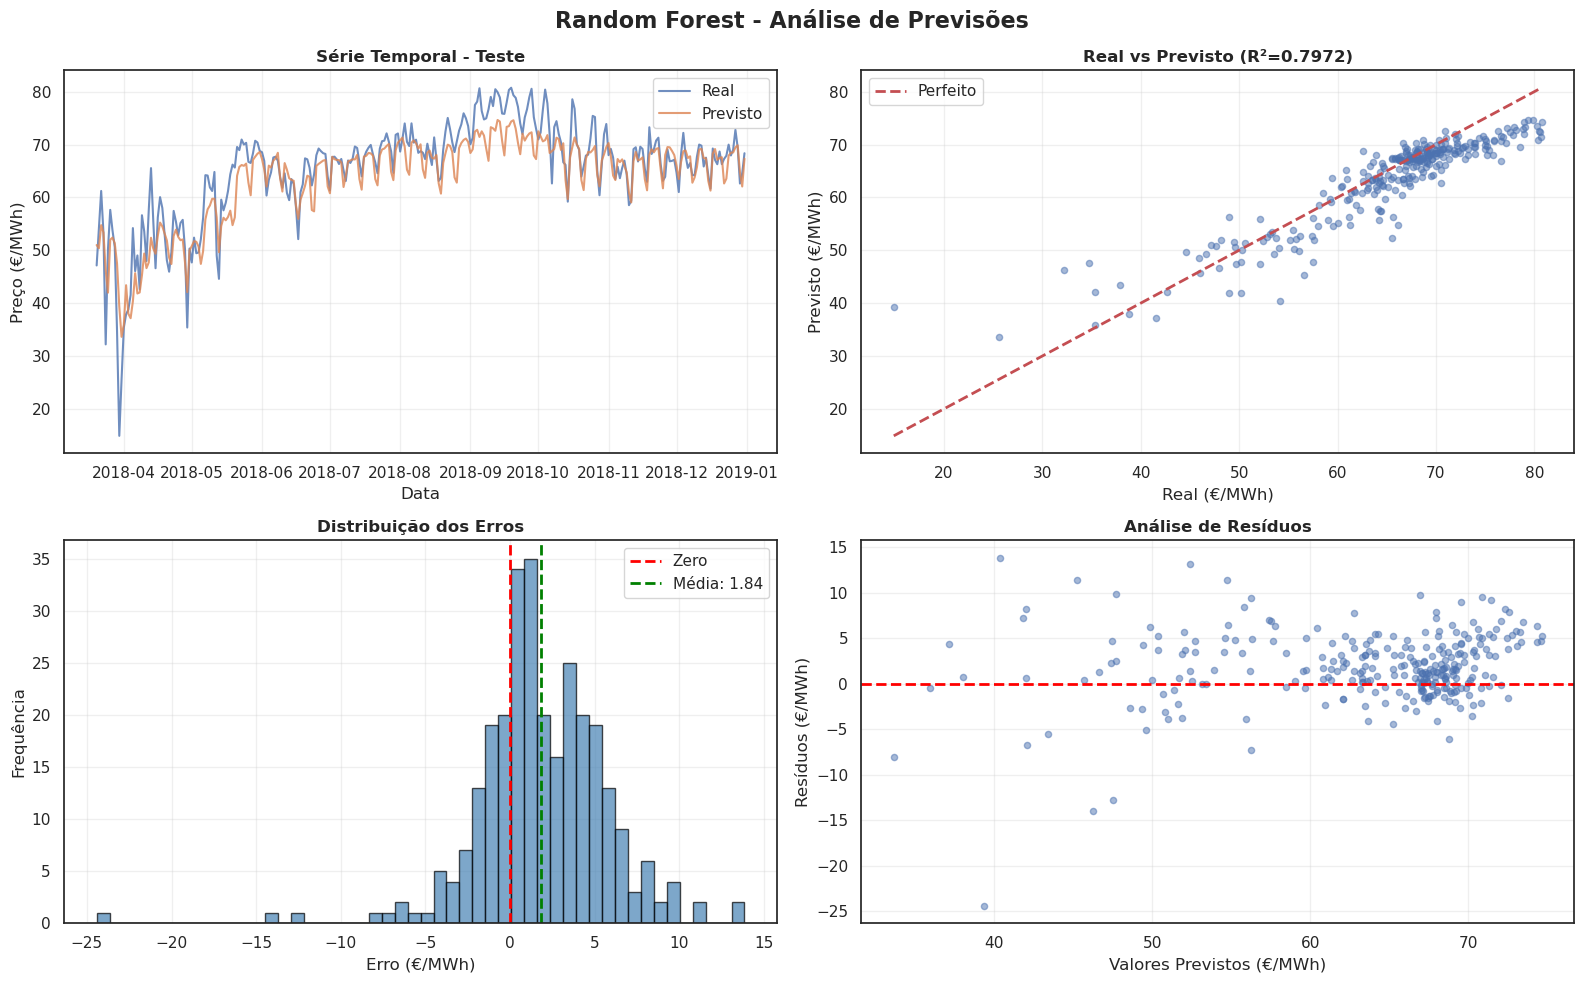

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Random Forest - Análise de Previsões', fontsize=16, fontweight='bold')

# 1. Série Temporal
axes[0, 0].plot(test_dates.values, y_test.values, label='Real', linewidth=1.5, alpha=0.8)
axes[0, 0].plot(test_dates.values, y_test_pred_rf, label='Previsto', linewidth=1.5, alpha=0.8)
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Preço (€/MWh)')
axes[0, 0].set_title('Série Temporal - Teste', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter Real vs Previsto
axes[0, 1].scatter(y_test, y_test_pred_rf, alpha=0.5, s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfeito')
axes[0, 1].set_xlabel('Real (€/MWh)')
axes[0, 1].set_ylabel('Previsto (€/MWh)')
axes[0, 1].set_title(f'Real vs Previsto (R²={metrics_rf_test["R²"]:.4f})', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribuição dos Erros
errors_rf = y_test.values - y_test_pred_rf
axes[1, 0].hist(errors_rf, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1, 0].axvline(x=errors_rf.mean(), color='green', linestyle='--', linewidth=2, 
                   label=f'Média: {errors_rf.mean():.2f}')
axes[1, 0].set_xlabel('Erro (€/MWh)')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].set_title('Distribuição dos Erros', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Resíduos
axes[1, 1].scatter(y_test_pred_rf, errors_rf, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Valores Previstos (€/MWh)')
axes[1, 1].set_ylabel('Resíduos (€/MWh)')
axes[1, 1].set_title('Análise de Resíduos', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Diagramas de Árvore

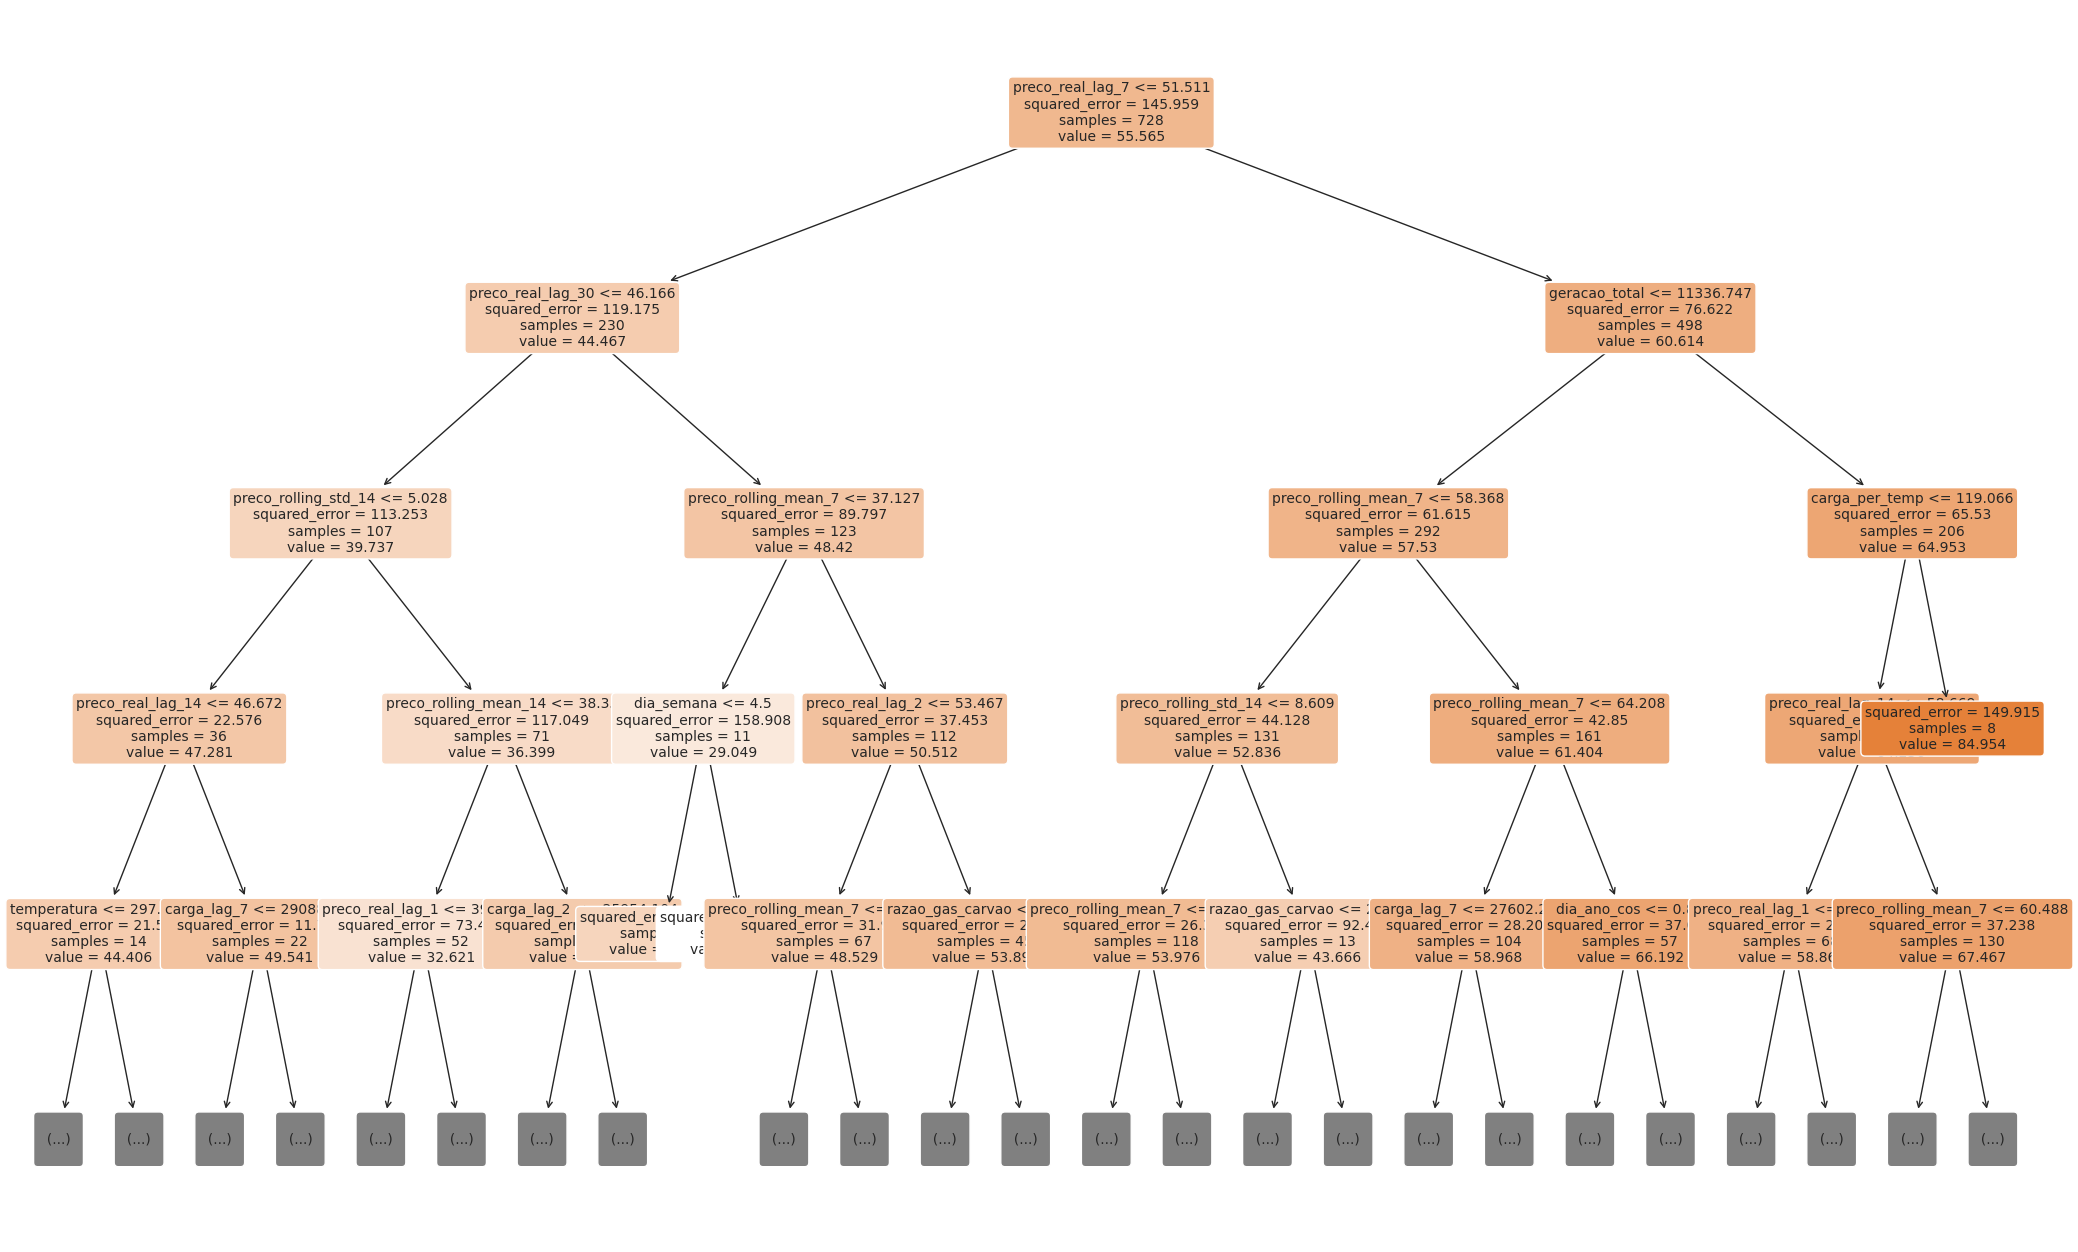

In [81]:
tree_id = 0
estimator = rf_model.estimators_[tree_id]

plt.figure(figsize=(26, 16))
plt.title(f"Árvore {tree_id} do Random Forest", fontsize=18, fontweight='bold')

plot_tree(
    estimator,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    max_depth=4,  # Limite visual para não ficar gigante
    fontsize=10
)

plt.show()

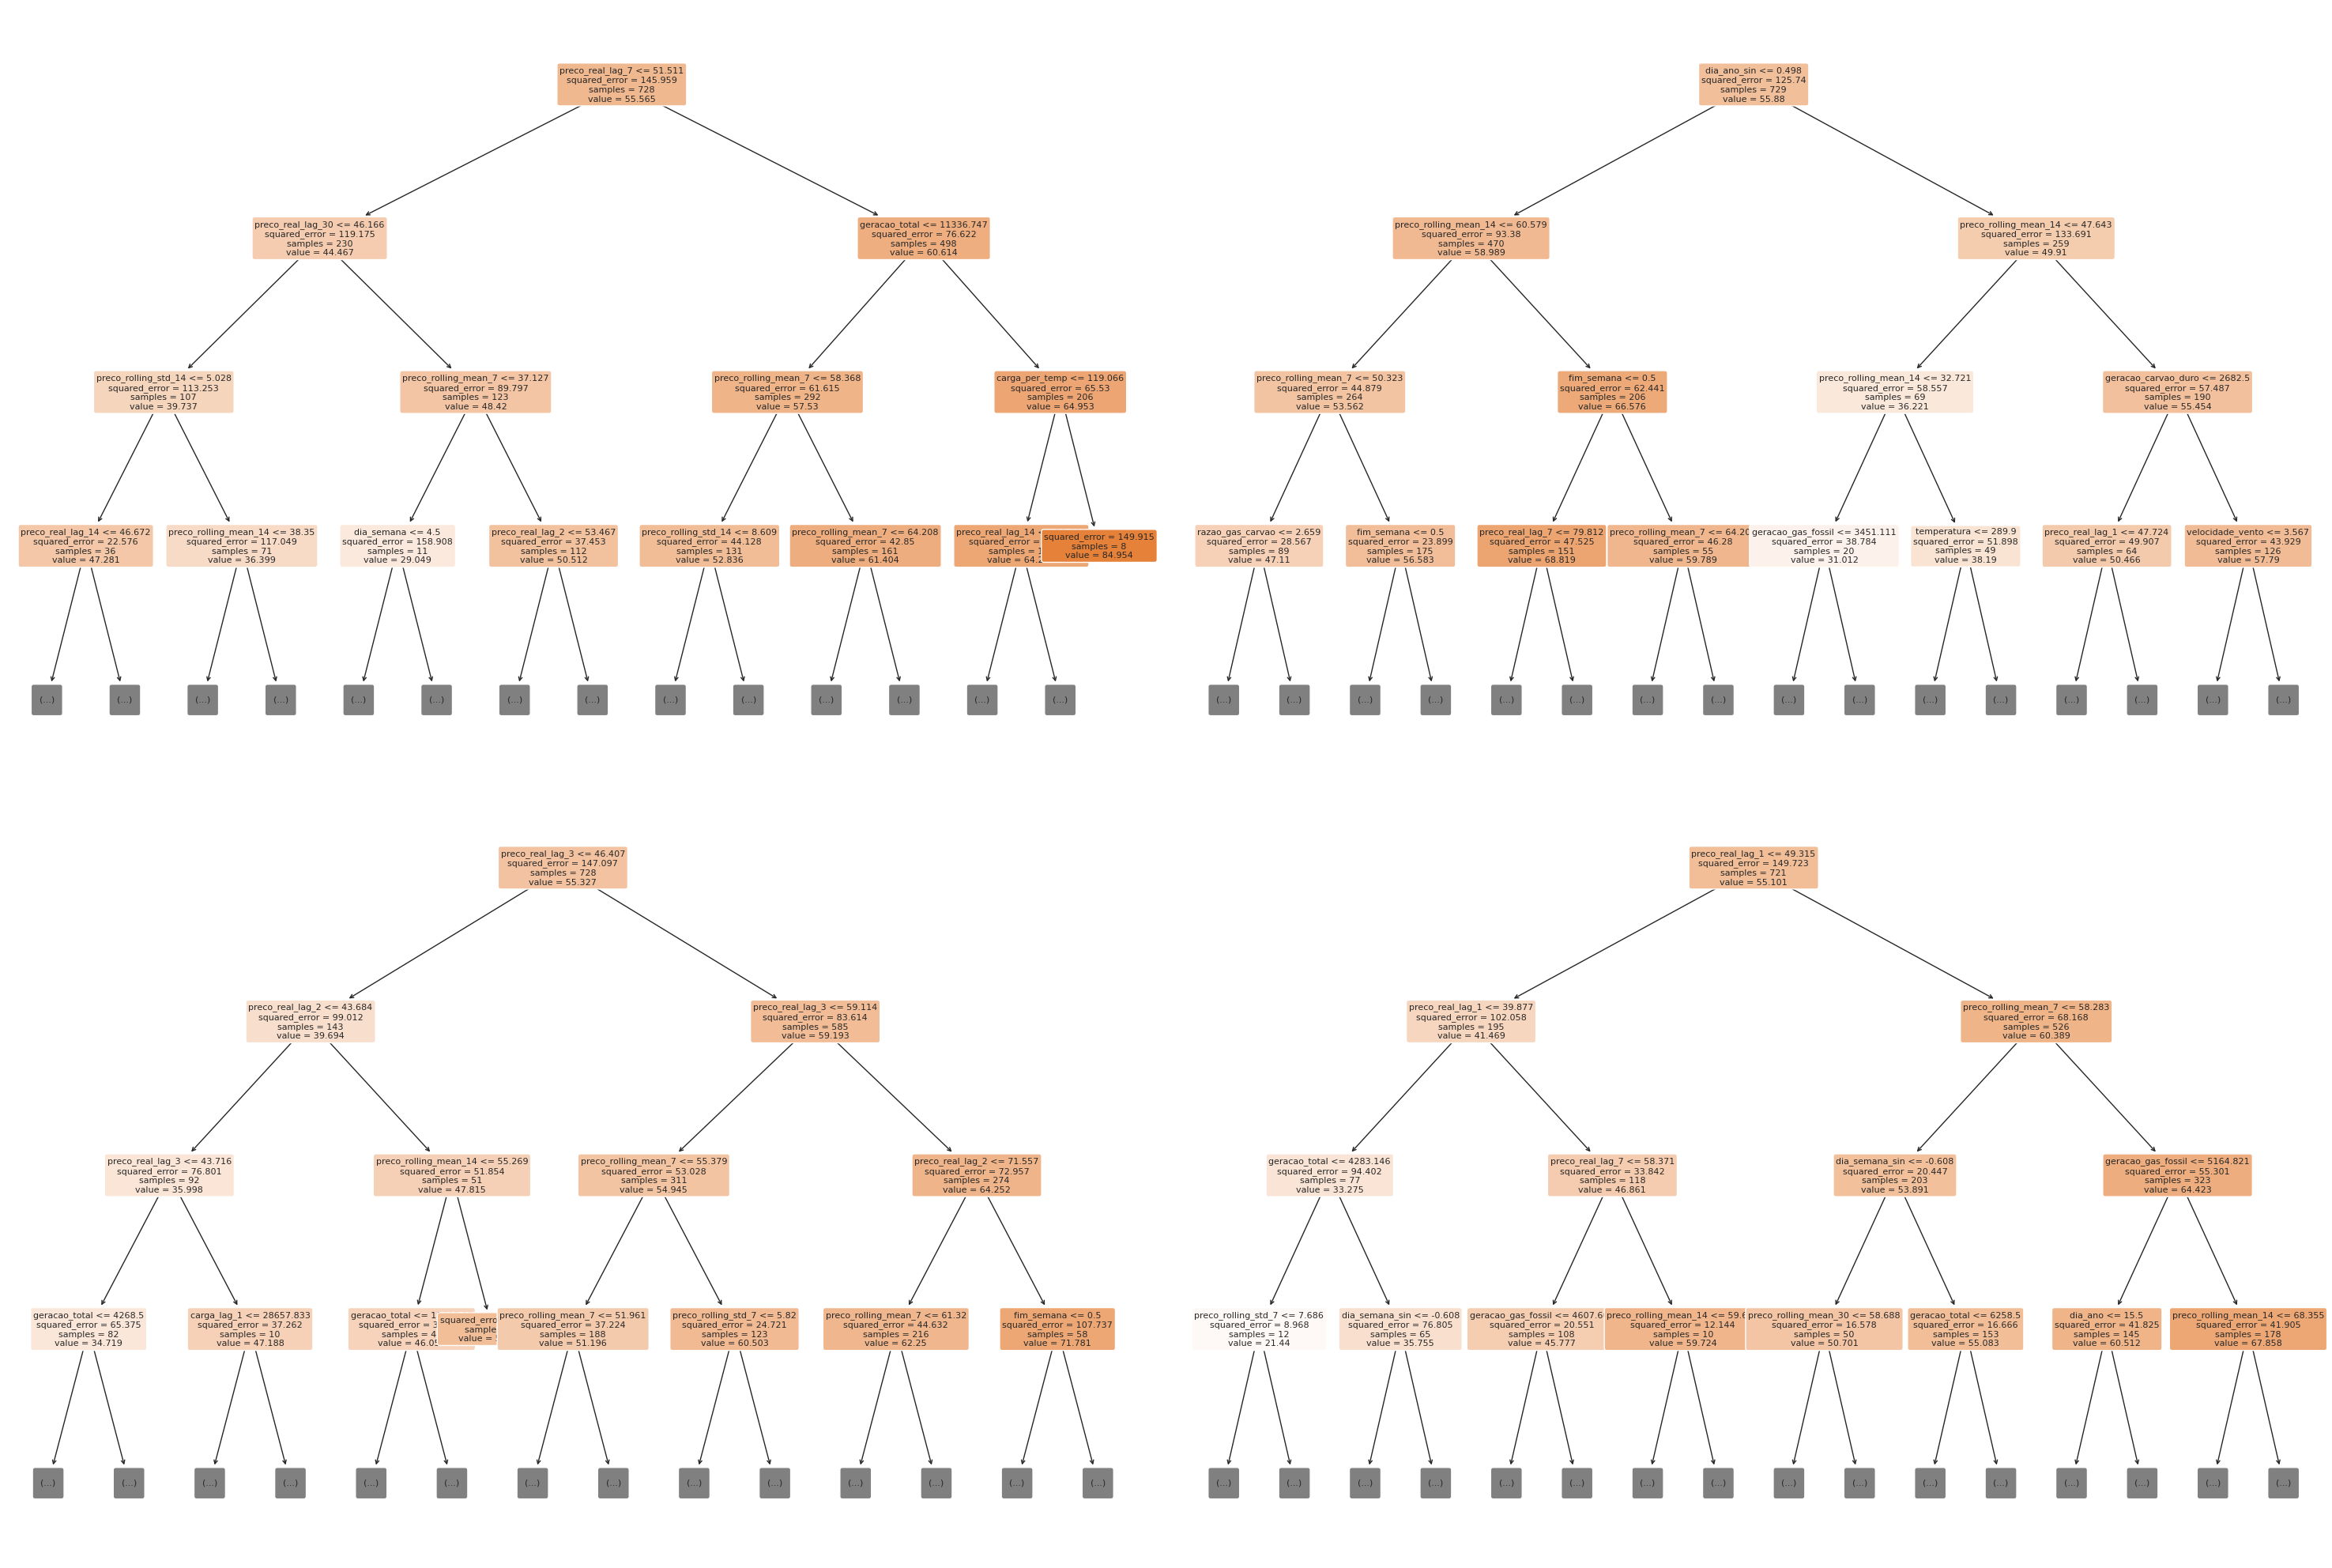

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(30, 20))

for i, ax in enumerate(axes.flatten()):
    estimator = rf_model.estimators_[i]
    ax.set_title(f"Árvore {i}", fontsize=14, fontweight='bold')
    plot_tree(
        estimator,
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        max_depth=3,
        fontsize=8,
        ax=ax
    )

plt.tight_layout()
plt.show()

## 15. Feature Importance - Random Forest


 Top 15 Features (Importância):
              Feature  Importance
 preco_rolling_mean_7      0.1951
     preco_real_lag_1      0.1652
preco_rolling_mean_14      0.0866
preco_rolling_mean_30      0.0797
     preco_real_lag_7      0.0789
     preco_real_lag_3      0.0544
     preco_real_lag_2      0.0488
    preco_real_lag_14      0.0323
  geracao_carvao_duro      0.0267
     velocidade_vento      0.0255
        geracao_total      0.0228
    preco_real_lag_30      0.0168
       dia_semana_sin      0.0167
   geracao_gas_fossil      0.0154
           dia_semana      0.0125


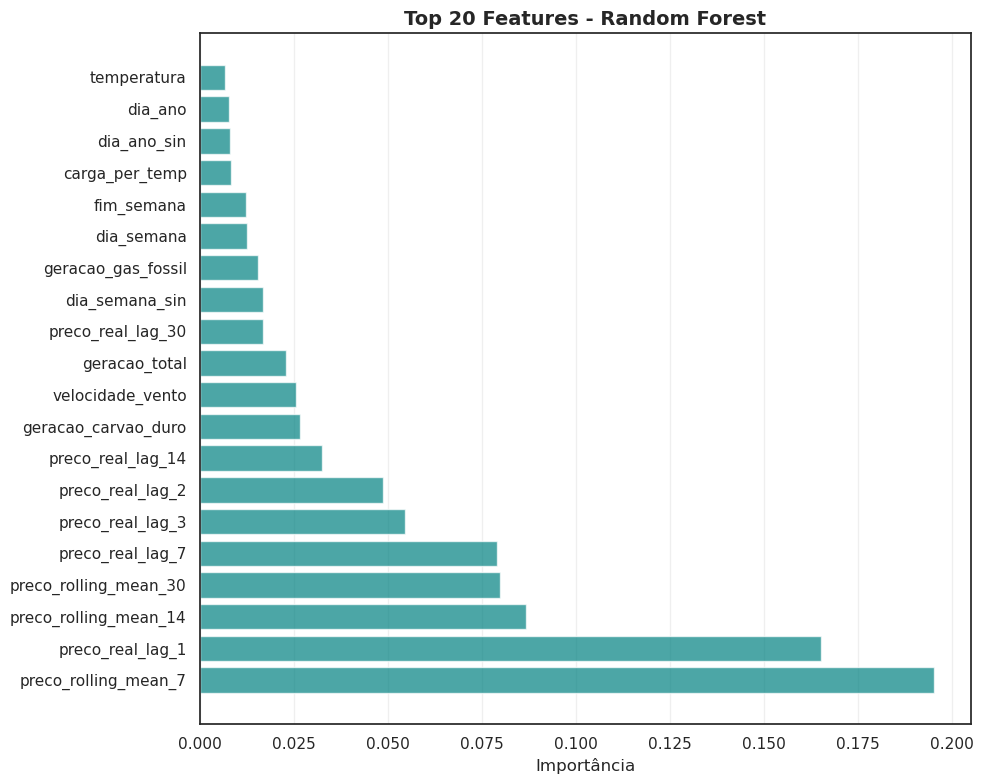

In [38]:
# Importância das features
feat_imp_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 15 Features (Importância):")
print(feat_imp_rf.head(15).to_string(index=False))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
top20_rf = feat_imp_rf.head(20)
ax.barh(range(len(top20_rf)), top20_rf['Importance'], color='teal', alpha=0.7)
ax.set_yticks(range(len(top20_rf)))
ax.set_yticklabels(top20_rf['Feature'])
ax.set_xlabel('Importância')
ax.set_title('Top 20 Features - Random Forest', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---
# PARTE 3: COMPARAÇÃO E CONCLUSÕES
---

## 16. Comparação dos Modelos


COMPARAÇÃO FINAL DOS MODELOS (TESTE)
   MAE   RMSE     R²  R² Ajustado  MAPE (%)  MPE (%)
2.8670 3.8699 0.8382       0.8104    4.9363   2.3788
3.1715 4.3330 0.7972       0.7623    5.5146   1.9297


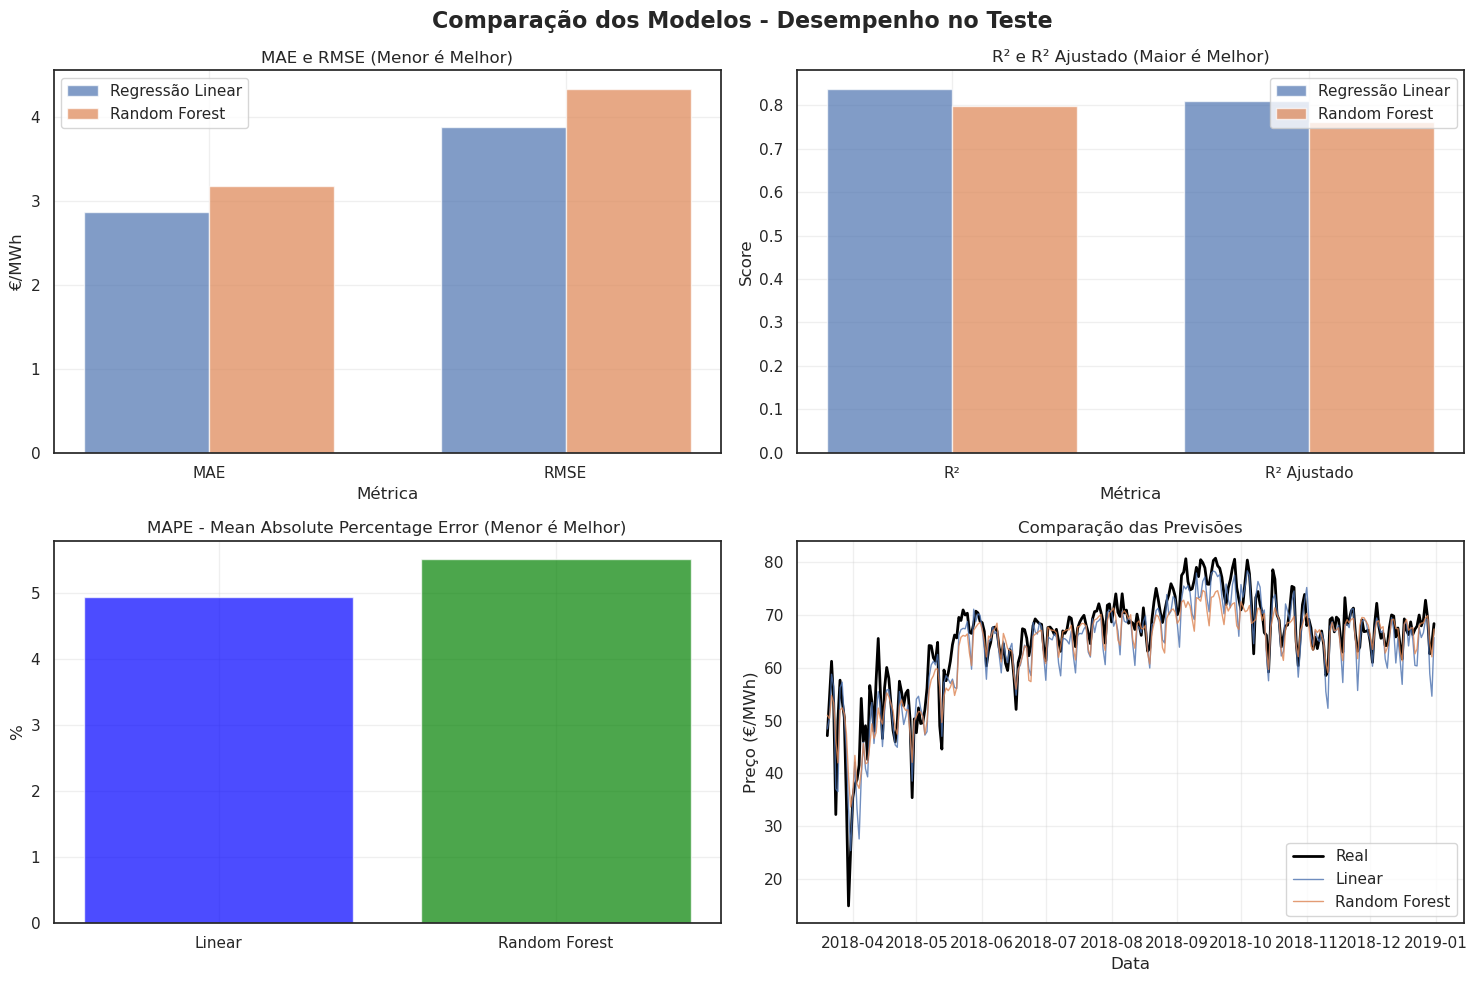

In [41]:
# Criar DataFrame de comparação
comparison_df = pd.DataFrame([
    metrics_lr_test,
    metrics_rf_test
])

# Remover colunas desnecessárias para comparação
comparison_df = comparison_df.drop(['Model', 'MSE'], axis=1)

print("\n" + "="*70)
print("COMPARAÇÃO FINAL DOS MODELOS (TESTE)")
print("="*70)
print(comparison_df.round(4).to_string(index=False))

# Visualizar comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparação dos Modelos - Desempenho no Teste', fontsize=16, fontweight='bold')

# 1. MAE e RMSE
metrics_compare = ['MAE', 'RMSE']
values_lr = [metrics_lr_test['MAE'], metrics_lr_test['RMSE']]
values_rf = [metrics_rf_test['MAE'], metrics_rf_test['RMSE']]

x = np.arange(len(metrics_compare))
width = 0.35

axes[0, 0].bar(x - width/2, values_lr, width, label='Regressão Linear', alpha=0.7)
axes[0, 0].bar(x + width/2, values_rf, width, label='Random Forest', alpha=0.7)
axes[0, 0].set_xlabel('Métrica')
axes[0, 0].set_ylabel('€/MWh')
axes[0, 0].set_title('MAE e RMSE (Menor é Melhor)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_compare)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. R² e R² Ajustado
metrics_compare2 = ['R²', 'R² Ajustado']
values_lr2 = [metrics_lr_test['R²'], metrics_lr_test['R² Ajustado']]
values_rf2 = [metrics_rf_test['R²'], metrics_rf_test['R² Ajustado']]

x2 = np.arange(len(metrics_compare2))

axes[0, 1].bar(x2 - width/2, values_lr2, width, label='Regressão Linear', alpha=0.7)
axes[0, 1].bar(x2 + width/2, values_rf2, width, label='Random Forest', alpha=0.7)
axes[0, 1].set_xlabel('Métrica')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('R² e R² Ajustado (Maior é Melhor)')
axes[0, 1].set_xticks(x2)
axes[0, 1].set_xticklabels(metrics_compare2)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. MAPE
mape_values = [metrics_lr_test['MAPE (%)'], metrics_rf_test['MAPE (%)']]
models = ['Linear', 'Random Forest']

axes[1, 0].bar(models, mape_values, color=['blue', 'green'], alpha=0.7)
axes[1, 0].set_ylabel('%')
axes[1, 0].set_title('MAPE - Mean Absolute Percentage Error (Menor é Melhor)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Previsões vs Real
axes[1, 1].plot(test_dates.values, y_test.values, label='Real', linewidth=2, color='black')
axes[1, 1].plot(test_dates.values, y_test_pred_lr, label='Linear', linewidth=1, alpha=0.8)
axes[1, 1].plot(test_dates.values, y_test_pred_rf, label='Random Forest', linewidth=1, alpha=0.8)
axes[1, 1].set_xlabel('Data')
axes[1, 1].set_ylabel('Preço (€/MWh)')
axes[1, 1].set_title('Comparação das Previsões')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 17. Conclusões e Próximos Passos

In [43]:
print("\n" + "="*70)
print("CONCLUSÕES E PRÓXIMOS PASSOS")
print("="*70)

# Determinar melhor modelo
best_model = "Random Forest" if metrics_rf_test['RMSE'] < metrics_lr_test['RMSE'] else "Regressão Linear"
improvement = abs(metrics_rf_test['RMSE'] - metrics_lr_test['RMSE']) / metrics_lr_test['RMSE'] * 100

print(f"\n MELHOR MODELO: {best_model}")
print(f"   • Melhoria no RMSE: {improvement:.2f}%")
print(f"   • RMSE do {best_model}: €{min(metrics_lr_test['RMSE'], metrics_rf_test['RMSE']):.4f}/MWh")

print(f"\n ANÁLISE DE DESEMPENHO:")
print(f"   • Random Forest geralmente performa melhor em dados complexos")
print(f"   • Regressão Linear é mais interpretável e rápida")
print(f"   • MAPE abaixo de 10% é considerado bom para séries temporais")

print(f"\n PRÓXIMOS PASSOS SUGERIDOS:")
print(f"   1. Tuning de hiperparâmetros com GridSearchCV")
print(f"   2. Testar outros modelos (XGBoost, LSTM, Prophet)")
print(f"   3. Adicionar mais features externas (feriados, eventos)")
print(f"   4. Implementar ensemble dos modelos")
print(f"   5. Validação cruzada temporal")

print(f"\n INSIGHTS DOS DADOS:")
print(f"   • Features de lag são cruciais para previsão de preços")
print(f"   • Sazonalidade temporal impacta significativamente")
print(f"   • Variáveis de oferta e demanda são preditores importantes")

print(f"\n PROJETO CONCLUÍDO COM SUCESSO!")
print("="*70)


CONCLUSÕES E PRÓXIMOS PASSOS

 MELHOR MODELO: Regressão Linear
   • Melhoria no RMSE: 11.97%
   • RMSE do Regressão Linear: €3.8699/MWh

 ANÁLISE DE DESEMPENHO:
   • Random Forest geralmente performa melhor em dados complexos
   • Regressão Linear é mais interpretável e rápida
   • MAPE abaixo de 10% é considerado bom para séries temporais

 PRÓXIMOS PASSOS SUGERIDOS:
   1. Tuning de hiperparâmetros com GridSearchCV
   2. Testar outros modelos (XGBoost, LSTM, Prophet)
   3. Adicionar mais features externas (feriados, eventos)
   4. Implementar ensemble dos modelos
   5. Validação cruzada temporal

 INSIGHTS DOS DADOS:
   • Features de lag são cruciais para previsão de preços
   • Sazonalidade temporal impacta significativamente
   • Variáveis de oferta e demanda são preditores importantes

 PROJETO CONCLUÍDO COM SUCESSO!
